In [39]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import requests

In [46]:
def fillna_linear_reg(model, x):
    if np.isnan(x['SkinThickness']):
        try:
            predicted = model.predict([[x['BMI']]])
            x['SkinThickness'] = predicted[0]
        except: pass
    return x

def preprocessing_train(data, feature_cols, zscore_cols, params = {}, outcomeCol='Outcome', outlierZscore=3):
    data[feature_cols+[outcomeCol]].copy()
    params = {}

    #preenchendo valores nulos com a média
    class0, class1 = data[data[outcomeCol] == 0].copy(), data[data[outcomeCol] == 1].copy()

    c0lr = class0[['BMI', 'SkinThickness']].dropna()
    model0, x0, st0 = LinearRegression(), c0lr['BMI'].to_numpy().reshape(-1, 1), c0lr['SkinThickness'] #['BMI'].to_numpy().reshape(-1, 1)
    model0.fit(x0, st0)
    for index, row in class0.iterrows():
        class0.loc[index,:] = fillna_linear_reg(model0, row)

    c1lr = class1[['BMI', 'SkinThickness']].dropna()
    model1, x1, st1 = LinearRegression(), c1lr['BMI'].to_numpy().reshape(-1, 1), c1lr['SkinThickness']
    model1.fit(x1, st1)
    for index, row in class1.iterrows():
        class1.loc[index,:] = fillna_linear_reg(model1, row)

    for column in feature_cols:
        c0m, c1m = class0[column].mean(), class1[column].mean()
        class0[column].fillna(value=c0m, inplace=True)
        class1[column].fillna(value=c1m, inplace=True)

    data = pd.concat([class0, class1],axis=0)

    #normalização z-score
    for column in [x for x in zscore_cols if x in feature_cols]:
        params[column] = {
            "mean": data[column].mean(),
            "std": data[column].std()
        }
        data[column] = (data[column] - params[column]["mean"]) / params[column]["std"]

    if('Age' in feature_cols):
        data['Age'] = data['Age'].apply(lambda x: 6 if x >= 60 else x // 10)

    return data, params

def preprocessing_test(data, feature_cols, zscore_cols, params):
    for column in [x for x in zscore_cols if x in feature_cols]:
        data[column] = (data[column] - params[column]["mean"]) / params[column]["std"]
    if('Age' in feature_cols):
        data['Age'] = data['Age'].apply(lambda x: 6 if x >= 60 else x // 10)

    return data

In [47]:
data = pd.read_csv('diabetes_dataset.csv')
feature_cols = ['Glucose', 'SkinThickness'] #,
zscore_cols = ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'SkinThickness']

data, params = preprocessing_train(data, feature_cols, zscore_cols)

selected = data[feature_cols+["Outcome"]].copy().dropna()
X = selected[feature_cols]
y = selected.Outcome

In [48]:
# Criando o modelo preditivo para a base trabalhada
print(' - Criando modelo preditivo')
neigh = KNeighborsClassifier(n_neighbors=3)

scores = {f'{n}':cross_val_score(neigh, X, y, cv=n, scoring="accuracy") for n in [2,3,5,10,20,30]}

neigh.fit(X, y)
scores['1'] = neigh.score(X, y)

for k in sorted(scores.keys(), key=lambda x:int(x)):
    print(f'k{k} cross validation: {scores[k].mean():.3f} +/- {scores[k].std():.3f}, between {scores[k].max():.3f} and {scores[k].min():.3f}')


 - Criando modelo preditivo
k1 cross validation: 0.830 +/- 0.000, between 0.830 and 0.830
k2 cross validation: 0.703 +/- 0.003, between 0.706 and 0.699
k3 cross validation: 0.708 +/- 0.018, between 0.733 and 0.689
k5 cross validation: 0.687 +/- 0.037, between 0.748 and 0.649
k10 cross validation: 0.689 +/- 0.043, between 0.759 and 0.632
k20 cross validation: 0.702 +/- 0.090, between 0.862 and 0.517
k30 cross validation: 0.697 +/- 0.091, between 0.842 and 0.474


In [51]:
#realizando previsões com o arquivo de
data_app = pd.read_csv('diabetes_app.csv')
processed = preprocessing_test(data_app, feature_cols, zscore_cols, params)
y_pred = neigh.predict(data_app[feature_cols])

c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


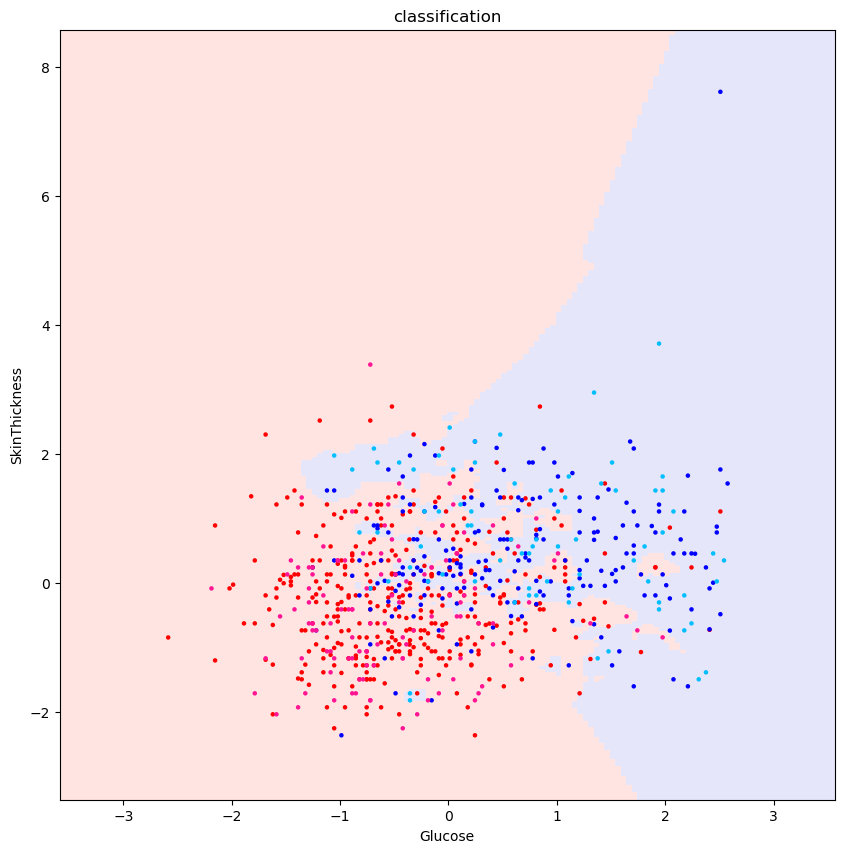

In [72]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['mistyrose', 'lavender'])
cmap_bold = ListedColormap(['red', 'blue'])
cmap_pred = ListedColormap(['deeppink','deepskyblue'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = 0.05
x_min, x_max = X[feature_cols[0]].min() - 1, X[feature_cols[0]].max() + 1
y_min, y_max = X[feature_cols[1]].min() - 1, X[feature_cols[1]].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10)) 
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[feature_cols[0]], X[feature_cols[1]], c=y, s=5, cmap=cmap_bold)
plt.scatter(processed[feature_cols[0]], processed[feature_cols[1]], s=5, c=y_pred, cmap=cmap_pred)
plt.xlabel(feature_cols[0])
plt.xlim(xx.min(), xx.max())
plt.ylabel(feature_cols[1])
plt.ylim(yy.min(), yy.max())
plt.title("classification")
plt.show()

In [73]:
y_pred

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
      dtype=int64)

In [74]:
# Enviando previsões realizadas com o modelo para o servidor
URL = "https://aydanomachado.com/mlclass/01_Preprocessing.php"

#TODO Substituir pela sua chave aqui
DEV_KEY = "ehtudoifelse"

# json para ser enviado para o servidor
data = {'dev_key':DEV_KEY,
        'predictions':pd.Series(y_pred).to_json(orient='values')}

# Enviando requisição e salvando o objeto resposta
r = requests.post(url = URL, data = data)

# Extraindo e imprimindo o texto da resposta
pastebin_url = r.text
print(" - Resposta do servidor:\n", r.text, "\n")

 - Resposta do servidor:
 {"status":"success","dev_key":"ehtudoifelse","accuracy":0.5918367346938775,"old_accuracy":0.59183673469388} 

